In [ ]:
import numpy as np
import os 
from PIL import Image
import matplotlib.pyplot as plt
from utils import load_image, show
from downsample.interpolation import (
    nearest_neighbor_downsample, 
    bilinear_interpolation_downsample,
    bicubic_interpolation_downsample, 
    pixel_unshuffle_downsample
)

from downsample.pooling import fractional_pool2d
# from filters import apply_filter
from filters.spatial_domain import (
    mean_filter,
    gaussian_filter,
    lanczos_filter,
    sinc_filter,
    kaiser_filter
)

from filters import apply_freq_filter, apply_spatial_filter
from utils import (
    calculate_mse,
    calculate_psnr,
    calculate_ssim,
    calculate_lpips
)

float64


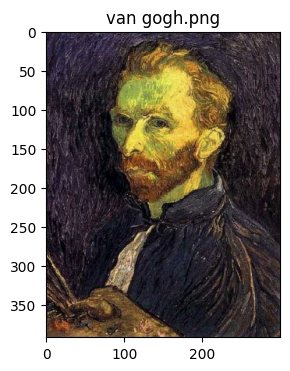

In [ ]:
img = load_image("./asserts/VanGogh.jpg")
print(img.dtype)
show(img, 'van gogh.png')
scale_factor = 2.5

## 1 下采样
### 1.1 基于插值法的采样方法
1. 最近邻下采样：为目标尺寸的像素点选择离它坐标最近的像素作为其值
2. 双线性插值下采样：先采样目标图像像素在原始图像中的位置（浮点数），并计算该位置周围四个像素点的加权平均值。在具体实现的过程中通过获取新图在原图中对应的一个 patch 解决。
3. 三线性插值下采样

392x300 -> 156x120
392x300 -> 156x120
392x300 -> 156x120


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03853694618069183..1.0019984283294339].


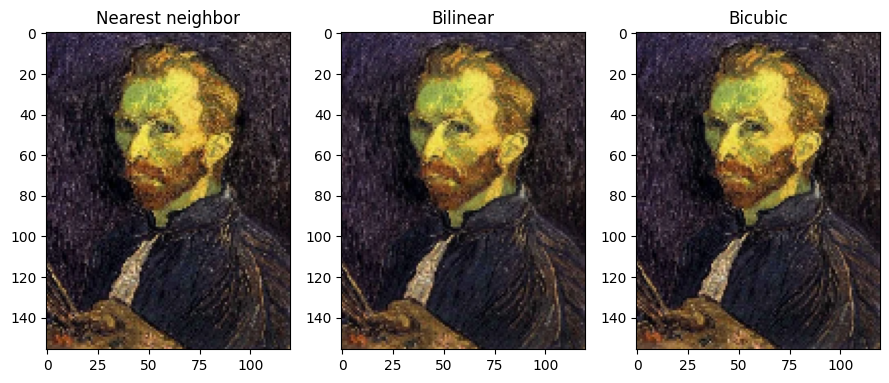

In [ ]:
# 最近邻下采样
# show(nearest_neighbor_downsample(img, scale_factor), 'Nearest Neighbor Down')
# # 双线性插值
# show(bilinear_interpolation_downsample(img, scale_factor), 'Bilinear Interpolation')
Interpolation_results = {
    "Nearest neighbor": nearest_neighbor_downsample(img, scale_factor),
    "Bilinear": bilinear_interpolation_downsample(img, scale_factor),
    "Bicubic": bicubic_interpolation_downsample(img, scale_factor),
}

titles = [key for key in Interpolation_results.keys()]
results = [value for value in Interpolation_results.values()]

show(results, titles)

### 1.2 池化下采样 

深度学习中常用的下采样方法，在一个卷积核大小的范围内进行局部聚合。
* 最大池化
* 最小池化
* 平均池化
* L2 pooling

Max pooling: 392x300 -> 156x120
Min pooling: 392x300 -> 156x120
Avg pooling: 392x300 -> 156x120
L2 pooling: 392x300 -> 156x120


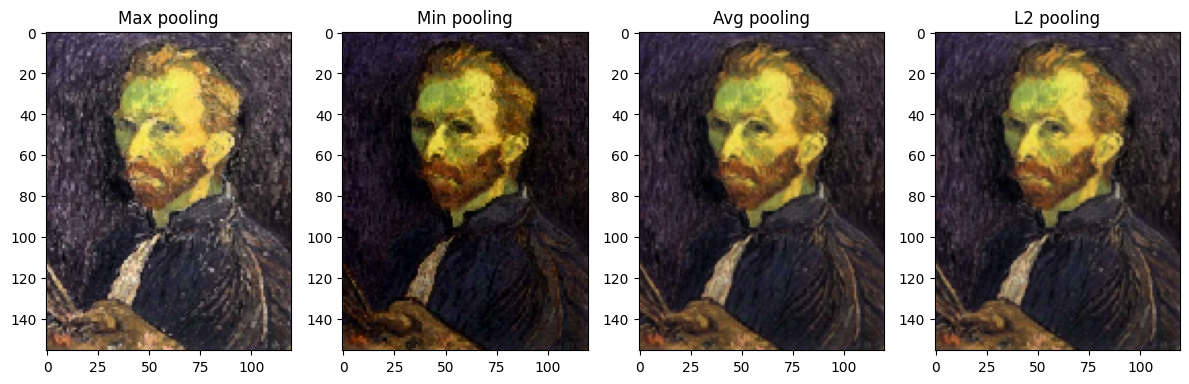

In [ ]:
pools = ['Max', 'Min', 'Avg', 'L2']
pooled_images = [fractional_pool2d(img, scale_factor, mode=mode) for mode in pools]
show(pooled_images, titles=[f'{mode} pooling' for mode in pools])

### 1.3 基于步幅卷积的下采样
​​原理:​​ 使用具有步长 (Stride) >1 的卷积核。例如，在 stride=2 的卷积中，卷积核每滑动2步计算一次输出。这导致输出特征图的宽高约为输入的1/2。就是边扫描边丢弃信息并直接进行下采样。

In [ ]:
from downsample.conv2d import generate_2dkernel, conv2d_downsample

In [ ]:
# 定义不同核参数
kernels_config = [
        {'type': 'random', 'size': 5},
        {'type': 'mean', 'size': 5},
        {'type': 'gaussian', 'size': 5},
        {'type': 'lanczos', 'size': 5, 'a': 2}
    ]

392x300 -> 156x120
392x300 -> 156x120
392x300 -> 156x120
392x300 -> 156x120


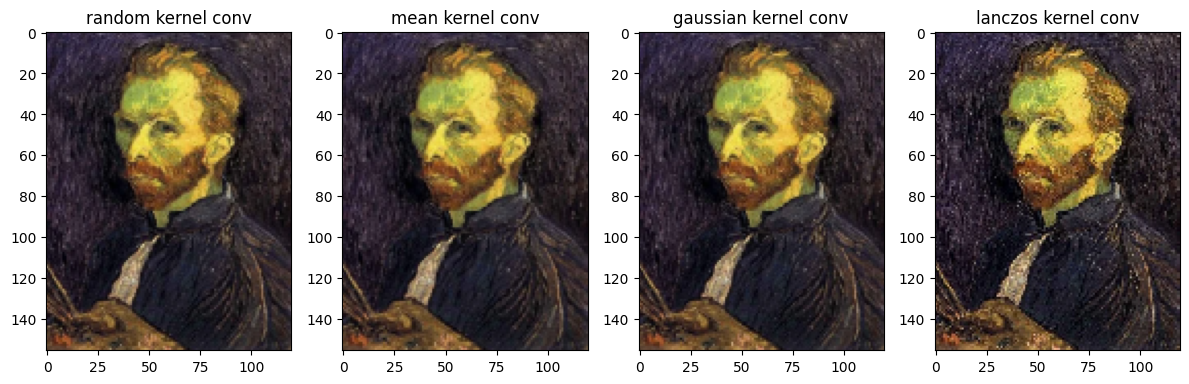

In [ ]:
kernels = [generate_2dkernel(**config) for config in kernels_config]
titles = [config['type'] + ' kernel conv' for config in kernels_config]
show([conv2d_downsample(img, scale_factor, kernel) for kernel in kernels], titles)

### 1.4 基于抗混叠滤波器的下采样
这里只实现了滤波器，可以结合上面实现的多种下采样方法进行。

滤波器分为频率域的滤波器和空间域的滤波器，频率域是先进行 fft 再变换再 ifft，包括：

* 高斯低通滤波器
* 理想低通滤波器
* 巴特沃斯低通滤波器

还有空间域的滤波，是用周围的像素修正原位置的像素，包括：

* 平均滤波
* 高斯滤波
* sinc 函数近似
* Lanczos 窗口
* Kaiser 窗

In [ ]:
spatial_filters = ['mean', 'gaussian', 'sinc', 'lanczos', 'kaiser']
filter_dict = {
    'mean': mean_filter,
    'gaussian': gaussian_filter,
    'sinc': sinc_filter,
    'lanczos': lanczos_filter,
    'kaiser': kaiser_filter
}
filter_results = []

for f in spatial_filters:
    filter_results.append(filter_dict[f](img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.17487136..1.0921504].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0998718e-17..1.0].


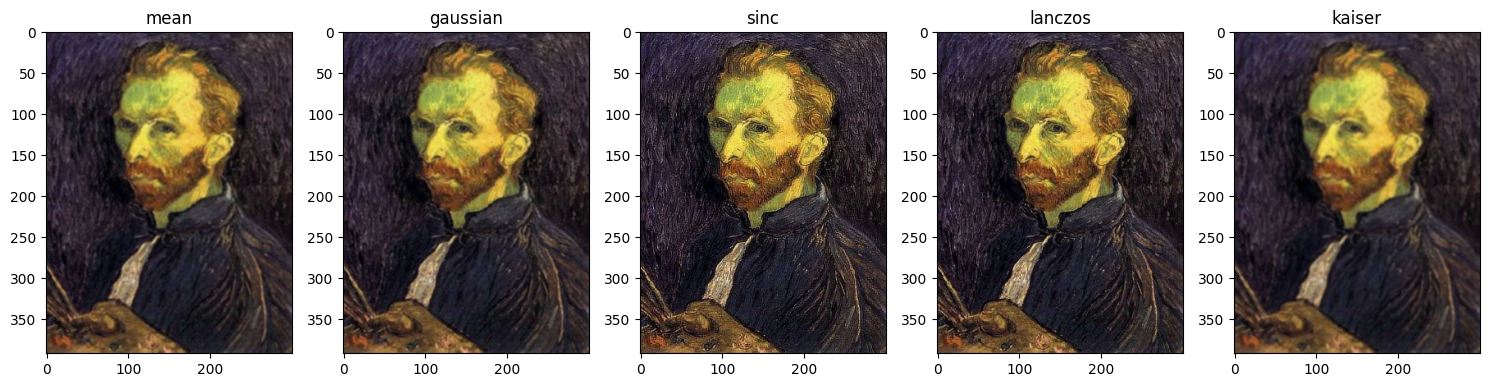

In [ ]:
show(filter_results, spatial_filters)

[np.float64(25.866206095335546), np.float64(24.317424550348306), np.float64(25.18800854398836)]


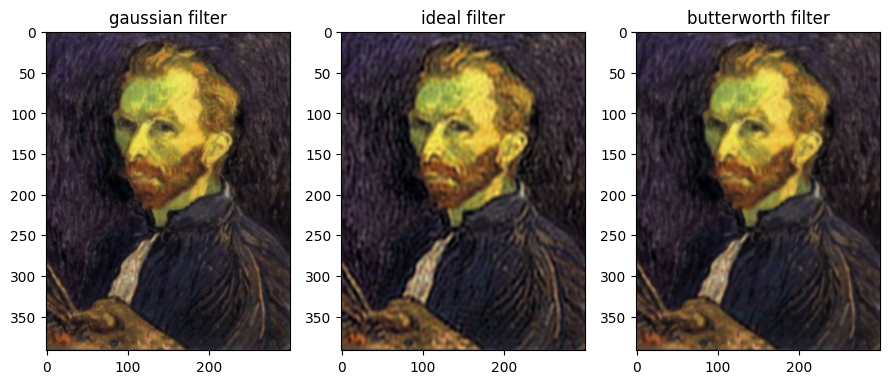

In [ ]:
freqs = [50]
for freq in freqs:
    filter_names = ['gaussian', 'ideal', 'butterworth']
    filtered_images = [apply_freq_filter(img, name, freq) for name in filter_names]
    titles = [f'{name} filter' for name in filter_names]
    show(filtered_images, titles)

### 1.5 Pixel Unshuffle /Space-to-Depth 下采样
​原理:​​ 基本是 ​​Pixel Shuffle​​上采样的逆操作。比如将一张 H x W x C 的图像，按块大小 r 拆分成 r x r 个patch（空间维度），将这些patch的像素值组织到深度通道（depth dimension）。
​​操作：​​ 输入尺寸 (B, C, H, W) -> 输出尺寸 (B, C * r*r, H//r, W//r)，按照 dim=1 每C维输出一个图像。
​​本质：​​ 通过改变张量维度实现尺寸减小和通道数增加。

Pixel unshuffule accept integer scale factor 2.


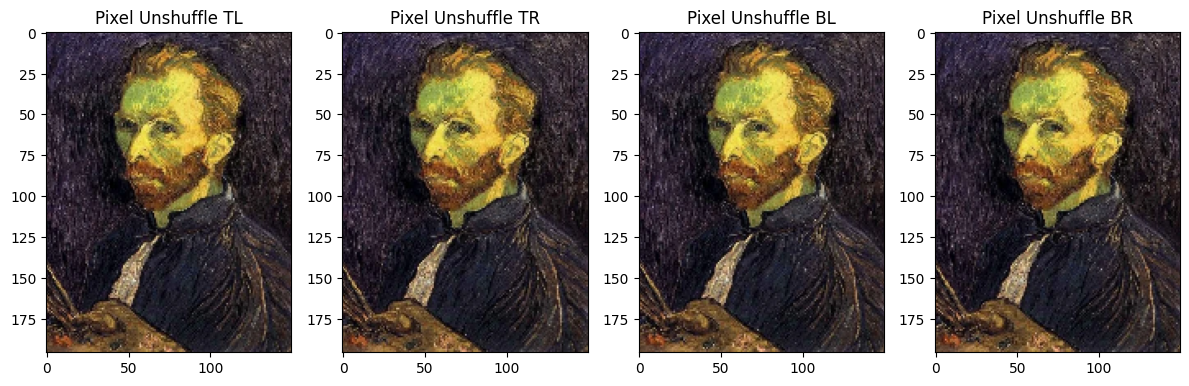

In [ ]:
pixel_unshuffle_res = pixel_unshuffle_downsample(img, scale_factor)
# show(pixel_unshuffle_downsample(img, scale_factor))
show(pixel_unshuffle_res, titles=[f'Pixel Unshuffle {x}' for x in ['TL', 'TR', 'BL', 'BR']])